# Data reduction for the hap-fr channel

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

#from gammapy.detect import compute_lima_on_off_image

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset
from gammapy.makers import (
    MapDatasetMaker,
    RingBackgroundMaker,
    SafeMaskMaker,    
)

#from gammapy.estimators import RingBackgroundEstimator

from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    #SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.18.2'

In [14]:
from pathlib import Path

path = Path("../../../../gammapy_data/GC_variability2020_full/hap-fr")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

## Datastore creation

In [15]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

OSError: File not found: $GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64/hdu-index.fits.gz

## Data selection

In [5]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(1.8, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=Angle([0.,50.], 'deg'))

obs_table = data_store.obs_table.select_observations(selection)
obs_table = obs_table.select_observations(selectionZEN)

In [6]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)

ids = obs_table["OBS_ID"].tolist()
observations = data_store.get_observations(ids, skip_missing=True)

for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations = data_store.get_observations(ids, skip_missing=True)
obs_table = obs_table.select_obs_id(ids)

Removed observations : 31539
Removed observations : 31577
Removed observations : 31578
Removed observations : 31579
Removed observations : 31580
Removed observations : 129467
Removed observations : 129471
Removed observations : 153792
Removed observations : 146971
Removed observations : 147119
Removed observations : 151790
Removed observations : 153030
Removed observations : 153031
Removed observations : 153791
Removed observations : 153793
Removed observations : 153794
Removed observations : 153810
Removed observations : 153811
Removed observations : 153812
Removed observations : 153813
Removed observations : 153836
Removed observations : 153837
Removed observations : 153838
Removed observations : 153839
Removed observations : 153840
Removed observations : 153841


In [7]:
len(obs_table)

862

### Grouping valid observations by year

In [8]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

In [9]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

## Creating the geometry for the dataset

In [10]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, e_bins, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy", interp="log"
)

In [11]:
# Creating the MapDataset objects

mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="maptot")

mapdatasetHESS1 = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="maphess1")
mapdatasetHESS2 = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="maphess2")
mapdatasetHESS1U = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="maphess1u")

mapdataset_dict = {}

for k in range (2004,2020):
    
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

## Datasets for each year (and the complete one)

In [13]:
%%time

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg) # J1745-303 ?
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

histo_thresh = dict()
histo_thresh_tot = []
histo_thresh1 = []
histo_thresh2 = []
histo_thresh1u = []

for year in range(2004,2020):
    
    offset_max = 1.8 * u.deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
    maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)

    spectrum = PowerLaw2SpectralModel(index=2.3)
    
    copy = []
    histo_thresh[year] = []

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2.0 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)
        
        dataset = maker_bkg.run(dataset)
        

        if dataset.background_model.norm.value >= 0.7:
            
            i = 0
            threshold = np.max(dataset.mask_safe.data[i, :,:])
        
            while threshold == False:
                i+=1
                threshold = np.max(dataset.mask_safe.data[0, :,:])
            
            histo_thresh[year].append(energy_axis.edges[i].value)
            histo_thresh_tot.append(energy_axis.edges[i].value)
            
            # The resulting dataset cutout is stacked onto the final one
            copy.append(obs)
            mapdataset_dict[year].stack(dataset)
            mapdataset_tot.stack(dataset)
            
            if (obs.obs_id > 20190 and obs.obs_id < 85000) or (obs.obs_id > 85294 and obs.obs_id < 85393):
                mapdatasetHESS1.stack(dataset)
                histo_thresh1.append(energy_axis.edges[i].value)
                
            if (obs.obs_id > 85392 and obs.obs_id < 123635) or (obs.obs_id > 84999 and obs.obs_id < 85293):
                mapdatasetHESS2.stack(dataset)  
                histo_thresh2.append(energy_axis.edges[i].value)
                
            if (obs.obs_id > 129418 and obs.obs_id < 153843):
                mapdatasetHESS1U.stack(dataset)
                histo_thresh1u.append(energy_axis.edges[i].value)
                
    yearly_obs[year] = copy


KeyboardInterrupt: 

## Saving the datasets

In [49]:
for year in range(2004,2020):
    
    filename = "mapdatasets/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(path/filename, overwrite=True)

In [50]:
filename = "mapdatasets/mapdataset_tot.fits.gz"
mapdataset_tot.write(path/filename, overwrite=True)

filename = "mapdatasets/mapdatasethess1.fits.gz"
mapdatasetHESS1.write(path/filename, overwrite=True)

filename = "mapdatasets/mapdatasethess2.fits.gz"
mapdatasetHESS2.write(path/filename, overwrite=True)

filename = "mapdatasets/mapdatasethess1u.fits.gz"
mapdatasetHESS1U.write(path/filename, overwrite=True)

# Collecting data on observation conditions

## Offset angles

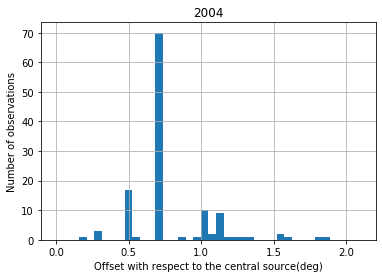

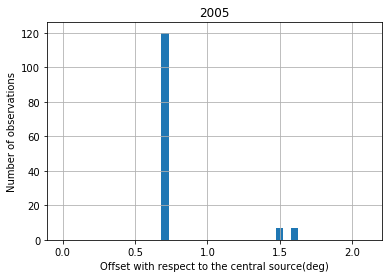

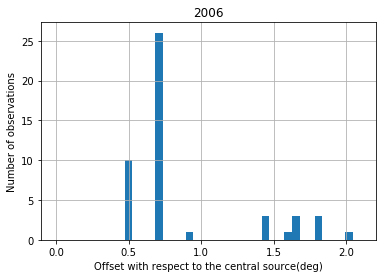

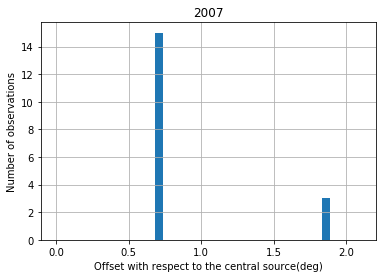

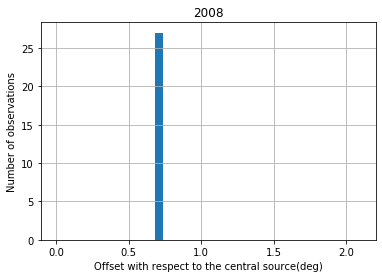

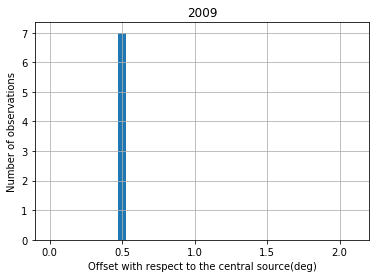

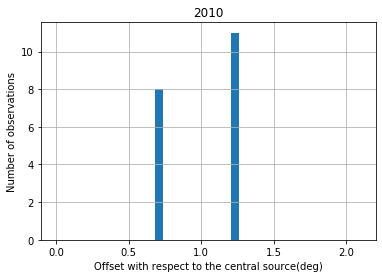

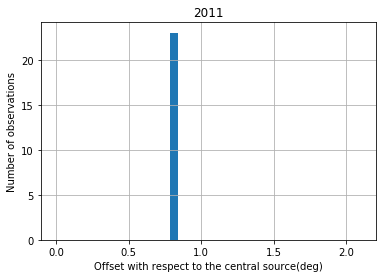

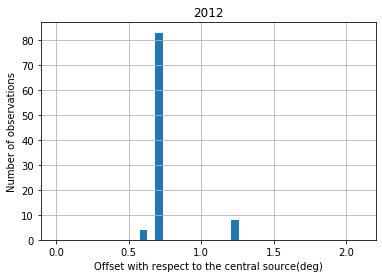

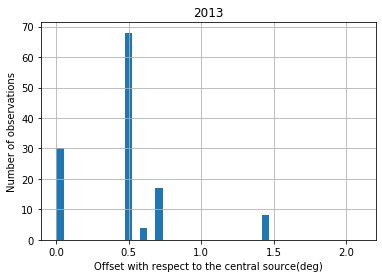

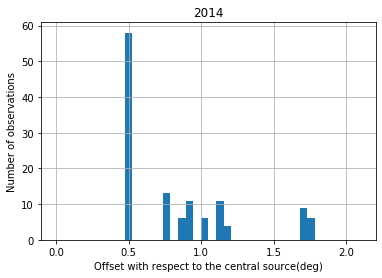

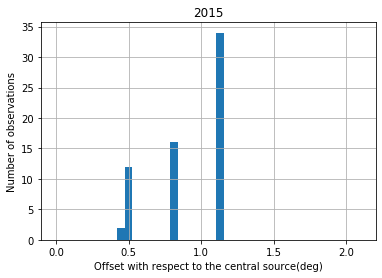

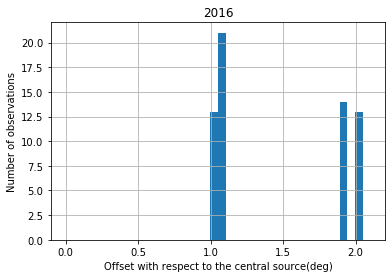

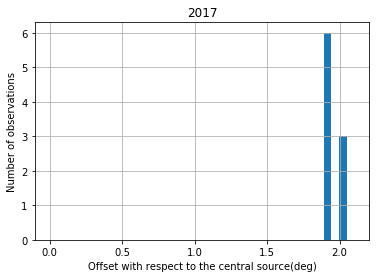

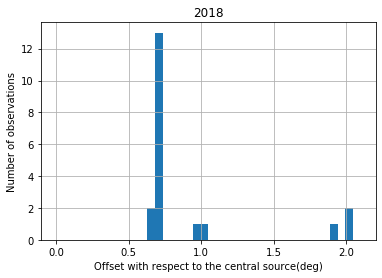

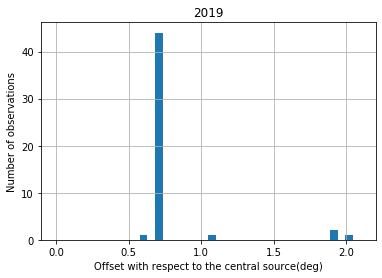

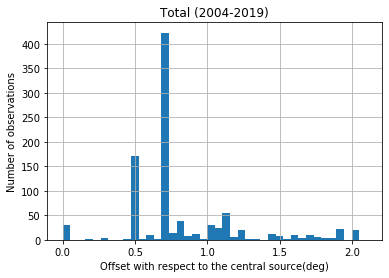

In [51]:
# Extracing offsets of observations (relative to SgrA*) for each year

sgra_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

histo_offset = dict()

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

offset_tot = []

for year in range(2004,2020):
    histo_offset[year] = []

    for obs in yearly_obs[year]:
        direction = obs.pointing_radec
        sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
        histo_offset[year].append(sep.value)
        offset_tot.append(sep.value)
        
    plt.figure()
    plt.hist(histo_offset[year], 40, (0.0, 2.1))
    
    plt.title(str(year))
    plt.grid()
    plt.xlabel("Offset with respect to the central source(deg)")
    plt.ylabel("Number of observations")
    
    name = "offsets_"+str(year)+"fr.pdf"
    plt.savefig(patho/name, overwrite=True)
    
plt.figure()
plt.hist(offset_tot, 40, (0.0, 2.1))
    
plt.title("Total (2004-2019)")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_tot_fr.pdf'
plt.savefig(patho/name, overwrite=True)

## Zenith angles

In [52]:
# Extracing zenithal angle of observation for each year

histo_zen = dict()

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

for year in range(2004,2020):  
    histo_zen[year] = []
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    histo_zen[year] = obs_table_year["ZEN_PNT"].tolist()
    
    plt.figure()
    plt.hist(histo_zen[year], 40, (5.0, 65.0))
    
    plt.title(str(year))
    plt.grid()
    plt.xlabel("Zenithal angle (deg)")
    plt.ylabel("Number of observations")
    
    name = "angzen_"+str(year)+"fr.pdf"
    plt.savefig(pathz/name, overwrite=True)

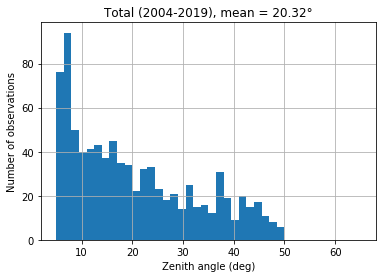

In [37]:
zen_tot = obs_table["ZEN_PNT"].tolist()
avg = np.mean(zen_tot)

plt.figure()
plt.hist(zen_tot, 40, (5.0, 65.0))
    
plt.title('Total (2004-2019), mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenith angle (deg)")
plt.ylabel("Number of observations")

 
name = "angzen_tot_fr.pdf"
plt.savefig(pathz/name, overwrite=True)

## Adding up LiveTime for each year

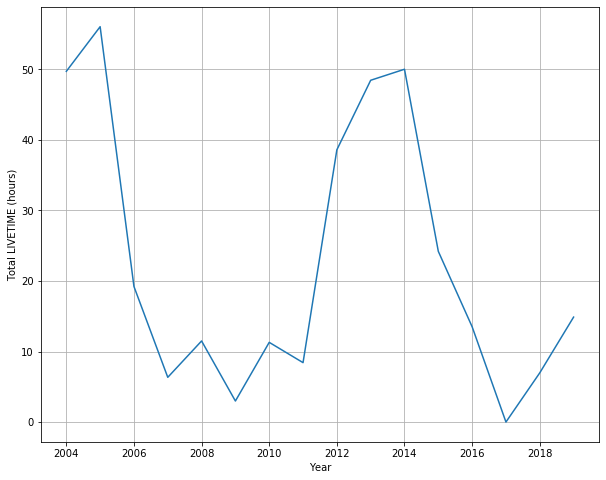

In [29]:
res = []

for year in range(2004,2020):
    obs_table_year = obs_table.select_observations(year_intervals[year])
    res.append(sum(obs_table_year["LIVETIME"].tolist())/3600)


plt.figure(figsize=(10,8))

plt.plot(range(2004,2020), res)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Total LIVETIME (hours)")
    
name = path/"livetime_plot_fr.pdf"
plt.savefig(name, overwrite=True)

## Energy thresholds

In [120]:
i

20

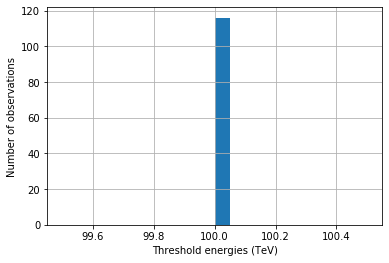

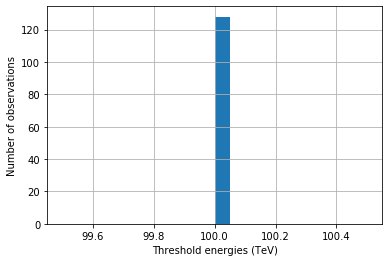

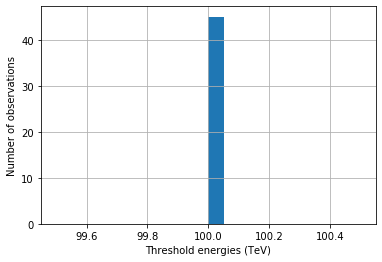

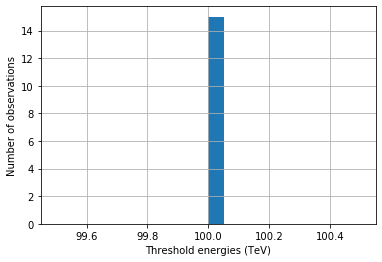

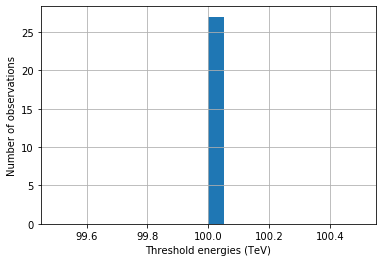

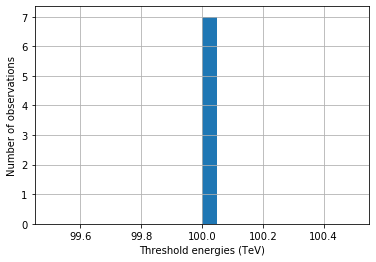

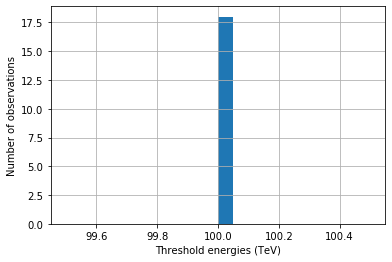

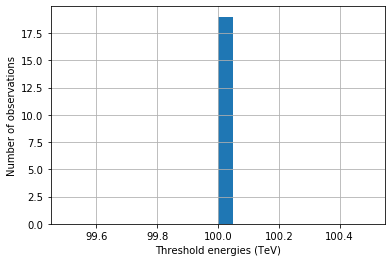

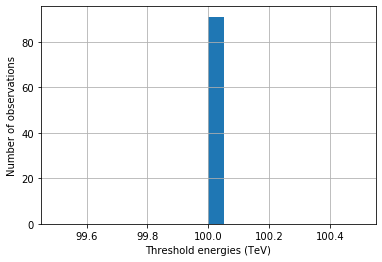

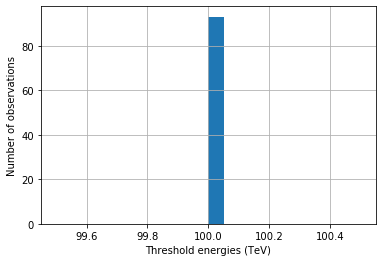

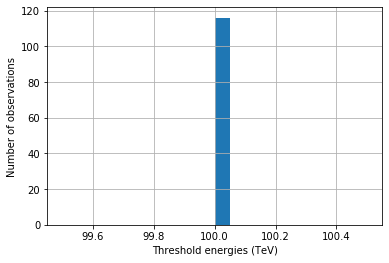

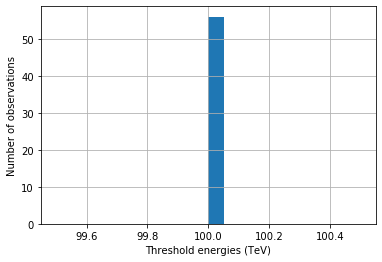

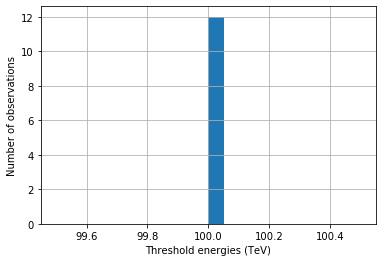

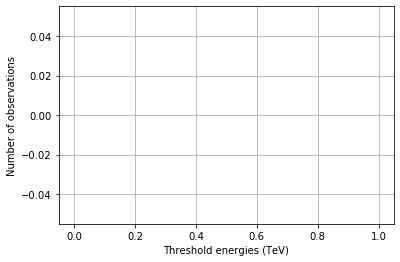

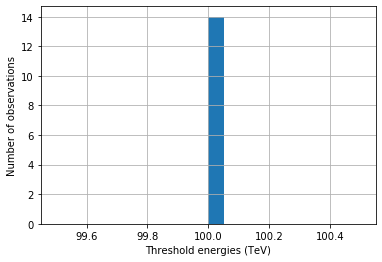

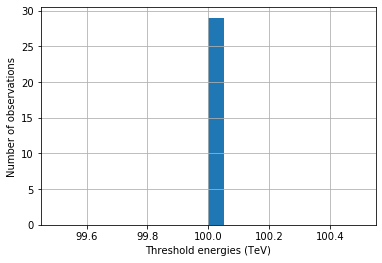

In [117]:
# affichage des histogrammes des énergies de seuil obtenu par bkg-peak, année par année

for year in range(2004,2020):
    
    plt.figure()
    plt.hist(histo_thresh[year], 20)
    
    plt.grid()
    plt.xlabel("Threshold energies (TeV)")
    plt.ylabel("Number of observations")
    
    name = "ethresh_"+str(year)+".pdf"
    
    #plt.savefig(path/name, overwrite=True)